In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
%run beautify_plots.py

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()

# The power of non-linear activation functions

In our introduction to Neural Networks, we identified non-linear activation functions as a key ingredient.

Let's examine, in depth, why this is so.

Many activation functions behave like a binary "switch"
- Converting the scalar value computed by the dot product
- Into a True/False answer
- To the question: "Is a particular feature present" ?

By changing the "bias" from $0$, we can move the threshold of the switch to an arbitrary value.

This allows us to construct a *piece-wise* approximation of a function
- The switch, in the region in which it is active, defines one piece
- Changing the bias/threshold allows us to relocate the piece

Consider the following function $f$:

<div>
    <center>Function to approximate</center>
    <br>
<img src=images/Piecewise_linear_1.jpg>
</div>

This function is
- Not continuous
- Define over set of discrete examples

$$ \langle \X, \y \rangle= [ \x^\ip, \y^\ip | 1 \le i \le m ]$$


<div>
    <center>Function to approximate, defined by examples </b>x</b></center>
    <br>
<img src=images/Piecewise_linear_2.jpg>
</div>

We can replicate the discrete function
- By a sequence of *step functions*
- Which create a piece-wise approximation of the function $f$

<div>
    <center>Piece-wise function approximation by step functions</center>
    <br>
<img src=images/Piecewise_linear.jpg>
</div>

We will show how to construct a step function using
- Dot product
- ReLU activation with $0$ threshold

Once we have a step, we can place the center of the step anywhere along the $\x$ axis
- By adjusting the threshold of the ReLU

The plan is:
- Construct a step function for the $i^{th}$ example
- Step $i$ becomes "active" when its input is at least $x^\ip$, using the bias of the ReLU
- Height of $i^{th}$ step is $f(\x^\ip)$
- The amount by which $f(\x)$ increases between steps is $(f(\x^{(i+1)} - f(\x^\ip))$

<div>
    <center>Step function: binary switch with threshold 0</center>
    <br>
<img src=images/Step_function_1.jpg>
</div>

<div>
    <center>Step function: binary switch with threshold - x^(i)</center>
    <br>
<img src=images/Step_function_2.jpg>
</div>

<div>
    <center>Impulse function: Center x^(i); width (x^(i+1) - x^(i))</center>
    <br>
<img src=images/Step_function_3.jpg>
</div>

That's the idea at a very intuitive level.

The rest of the notebook demonstrates exactly how to achieve this.

# Universal function approximator
A Neural Network is a Universal Function Approximator.

This means that an NN that is sufficiently 
- wide (large number of neurons per layer) 
- and deep (many layers; deeper means the network can be narrower)

can approximate (to arbitrary degree)
the function represented by the training set.

Recall that the training data $\langle \X, \y \rangle = [ (\x^\ip, \y^\ip) |  1 \le i \le m ]$ is a sequence of input/target pairs.

This may look like a strange way to define a function 
- but it is indeed a mapping from the
domain of $\x$ (i.e., $\mathcal{R}^n$) to the domain of $\y$ (i.e., $\mathcal{R})$
- subject to $\y^i = \y^{i'} \;  \text{if} \; \x^i = \x^{i'}$ (i.e., mapping is unique).

We give an intuitive proof for a one-dimensional function
- all vectors $\x, \y, \W, \b$ are length 1.

For simplicity, let's assume that the training set
is presented in order of increasing value of $\x$, i.e.
$$
\x^{(0)} \lt \x^{(1)} \lt \ldots \x^{(m)}
$$

Consider a single neuron with a ReLU activation, computing
$$
\max{}(0, \W \x + \b)
$$

Let's plot the output of this neuron, for varying $\W, \b$.

The slope of the neuron's activation is $\W$ and the intercept is $\b$.

By making slope $\W$ extremely large, we can approach a vertical line.

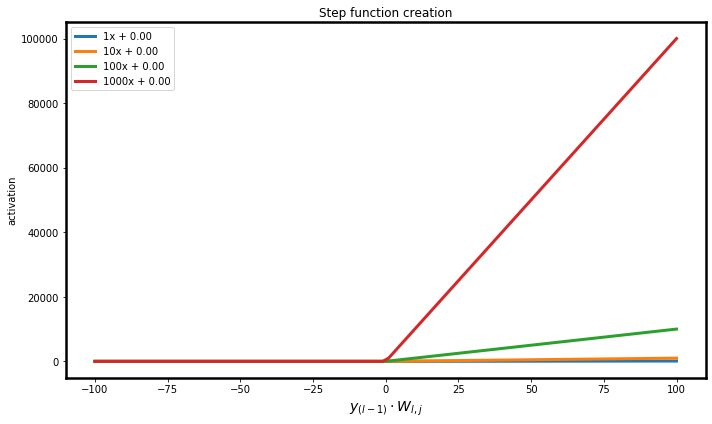

In [5]:
_ = nnh.plot_steps( [ nnh.NN(1,0), nnh.NN(10,0), nnh.NN(100,0), nnh.NN(1000,0), ])

And by varying the intercept (bias) we can shift this vertical line to any point on the feature axis.

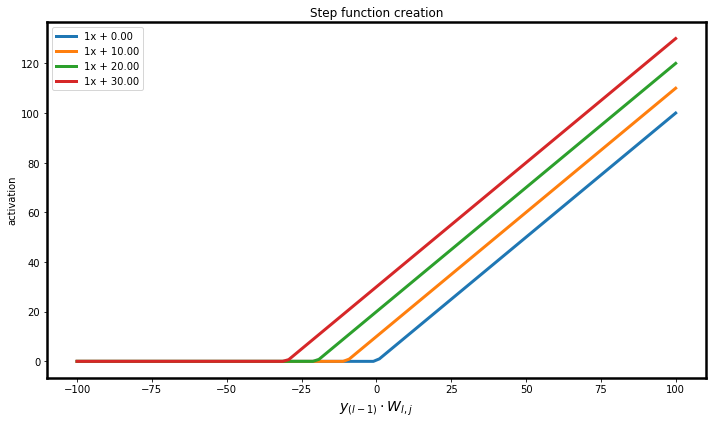

In [6]:
_ = nnh.plot_steps( [ nnh.NN(1,0), nnh.NN(1,10), nnh.NN(1,20), nnh.NN(1,30), ])

With a little effort, we can construct a neuron 
- With near infinite slope
- Rising from the x-axis at any offset.

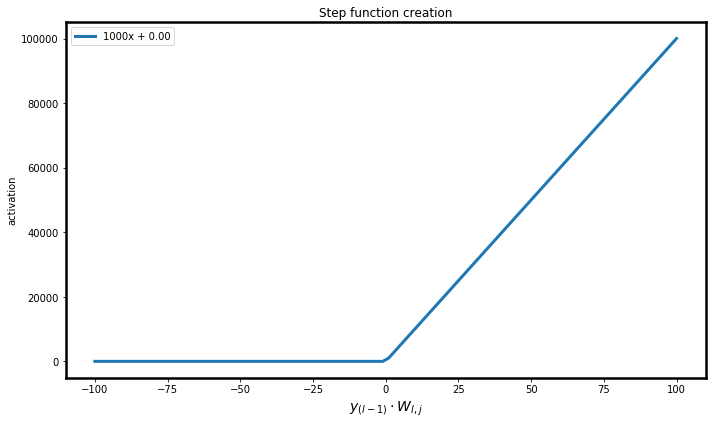

In [7]:
slope = 1000
start_offset = 0

start_step = nnh.NN(slope, -start_offset)

_= nnh.plot_steps( [  start_step ] )

If we create a neuron with intercept "epsilon" from the first neuron


In [8]:
end_offset = start_offset + .0001

end_step = nnh.NN(slope,- end_offset)


and add the two neurons together, we can approximate a step functiion
- unit height
- 0 output at inputs
less than the x-intercept
- unit output for all inputs greater than the intercept).

(The sigmoid function is even more easily transformed into a step function).

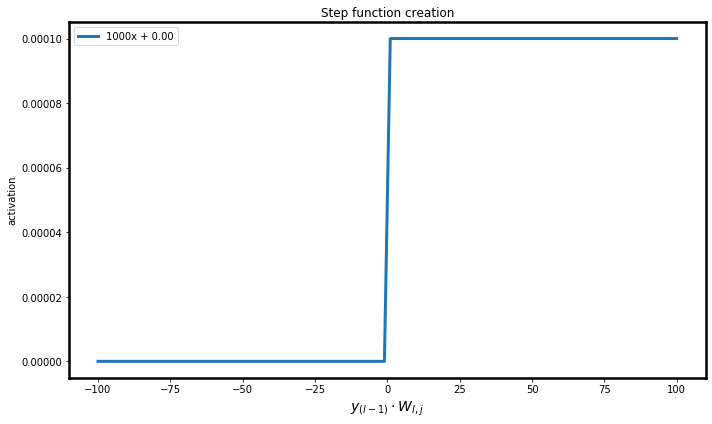

In [9]:
step= {"x": start_step["x"], 
       "y": start_step["y"] - end_step["y"],
       "W": slope,
       "b": 0
      }
_= nnh.plot_steps( [  step ] )

Let us construct $m$ step neurons
- step neuron $i$ with intercept $\x^\ip$, for $1  \le i \le m $

If we connect the $m$ step neurons to a "final" neuron with $0$ bias, linear activation, and weights

$$
\begin{array}[lll] \\
\W_1 & = & \y^{(1)} \\
\W_i & = & \y^{(i)} - \sum_{i'=1}^{i-1}\W_{i'} \\
\end{array}
$$

<table>
    <tr>
        <th><center>Function Approximation by Step functions</center></th>
    </tr>
    <tr>
        <td><img src="images/Universal_Function_Step.jpg" width=1200></td>
    </tr>
</table>

We claim that the output of this neuron approximates the training set.

To see this: 
- Consider what happens when we input $\x^\ip$ to this network.
- The only step neurons that are active (non-zero) are those corresponding
to inputs $1 \le i' \le i$.
- The output of the final neuron is the sum of the outputs of the first $i$ step neurons.
- By construction, this sum is equal to $\y^\ip$.

Thus, our two layer network outputs $\y^\ip$ given input $\x^\ip$.

**Financial analogy:** if we have call options with completely flexible strikes and same expiry,
we can mimic an arbitrary payoff in a similar manner.

In [10]:
print("Done")

Done
